### Import All Results

We need to parse multiple CSV files into a single data-frame. The headers for each are as follows:
```
"Benchmark","Mode","Threads","Samples","Score","Score Error (99,9%)","Unit","Param: configStr"
```
We are mostly interested in "Benchmark", "Score", "Score Error (99,9%)", and "Unit.

The directory format for the data we need to parse is as follows:
```
 |- results
    |- <driver>
       |- <project>
          |- results-Xmx<mem>G-write.csv
          |- results-Xmx<mem>G-read.csv
```
The driver, project, and memory information also need to become columns in the dataframe.

### AST Creation Plotting

In [111]:
import os

import numpy as np
import pandas as pd

# Define the directory containing the results
base_dir = 'results'

# Define the columns of interest
columns_of_interest = ["Benchmark", "Score", "Score Error (99.9%)", "Unit"]

# List to store individual dataframes
dataframes = []

# Some special variables to differentiate different erroneous outcomes on
OOM = 101010101
TIMEOUT = 202020202
EXCEPTION = 303030303

patterns = {
    OOM: '//',
    TIMEOUT: '\\\\',
    EXCEPTION: 'o'
}


def check_if_file_has_phrase(file_p, phrase) -> bool:
    try:
        with open(file_p, 'r') as f:
            for line in f:
                if phrase in line:
                    return True
    except Exception as e:
        print(f"Error reading file {file_p}: {e}")
    return False


def map_driver_name(name: str) -> str:
    if name == "overflowdb":
        return "OverflowDB"
    elif name == "tinkergraph":
        return "TinkerGraph"
    elif name == "neo4j-embedded":
        return "Neo4j (Embedded)"
    elif name == "flatgraph":
        return "FlatGraph"
    else:
        return "Unknown ({})".format(name)


# Walk through the directory structure
for root, dirs, files in os.walk(base_dir):
    for file in files:
        file_path = os.path.join(root, file)
        # Extract <driver>, <project>, and <mem> from the path
        parts = file_path.split(os.sep)
        driver = map_driver_name(parts[1])
        project = parts[2].title()
        mem = file.split('-')[1][3:-1]  # Extracting <mem> from 'results-Xmx<mem>G-*.csv'
        typ = file.split('-')[2].split('.')[0]
        
        result_file = file_path.replace(".txt", ".csv").replace("output", "results")
        if file.endswith('-read.txt') and (not os.path.exists(result_file) or os.path.getsize(result_file) == 0):
            data = {}
            err = EXCEPTION
            if check_if_file_has_phrase(file_path, "benchmark timed out"):
                print(f"Timeout occurred in {file_path}")
                err = TIMEOUT
            elif check_if_file_has_phrase(file_path, "[warn] Canceling execution..."):
                print(f"Out-of-memory occurred in {file_path}")
                err = OOM

            read_arr = ["astDFS", "astUp", "callOrderExplicit", "callOrderTrav", "indexedMethodFullName", "orderSum",
                        "unindexedMethodFullName"]
            df = pd.DataFrame({
                'Score': [err] * len(read_arr),
                'Error': [0.0] * len(read_arr),
                'Benchmark': read_arr,
                'Unit': ['s/op'] * len(read_arr)
            })
        elif file.endswith('-write.txt') and (not os.path.exists(result_file) or os.path.getsize(result_file) == 0):
            data = {}
            err = EXCEPTION
            if check_if_file_has_phrase(file_path, "benchmark timed out"):
                print(f"Timeout occurred in {file_path}")
                err = TIMEOUT
            elif check_if_file_has_phrase(file_path, "[warn] Canceling execution..."):
                print(f"Out-of-memory occurred in {file_path}")
                err = OOM

            df = pd.DataFrame({
                'Score': [err],
                'Error': [0.0],
                'Benchmark': ["createAst"],
                'Unit': ['s/op']
            })
        elif file.endswith('.csv'):
            # Check if the file is empty
            if os.path.getsize(file_path) == 0:
                print(f"Skipping empty file: {file_path}")
                continue

            else:
                # Read the CSV file
                df = pd.read_csv(file_path,
                                 usecols=columns_of_interest)  #, dtype={'Score': float, 'Score Error (99,9%)': float})

                # Rename the column "Score Error (99,9%)" to "Error"
                df.rename(columns={"Score Error (99.9%)": "Error"}, inplace=True)

                # Clean score data
                df['Score'] = df['Score'].replace(',', '.').astype(float)
                df['Error'] = df['Error'].replace(',', '.').astype(float)
        else:
            df = None

        if df is not None and not df.empty:
            # Add the extracted information as new columns
            df['Database'] = driver
            df['Project'] = project
            df['Mem'] = int(mem)
            df['Type'] = typ.lower()
            # Append the dataframe to the list
            dataframes.append(df)

# Concatenate all dataframes into a single dataframe
final_df = pd.concat(dataframes, ignore_index=True)

# Display the final dataframe
print(final_df)


# JMH version: 1.37

# VM version: JDK 21.0.2, OpenJDK 64-Bit Server VM, 21.0.2+13-58

# VM invoker: /home/dave/.sdkman/candidates/java/21.0.2-open/bin/java

# VM options: -Xmx8G -XX:+UseZGC

# Blackhole mode: compiler (auto-detected, use -Djmh.blackhole.autoDetect=false to disable)

# Warmup: 5 iterations, 30 s each

# Measurement: 5 iterations, 10 s each

# Timeout: 10 min per iteration

# Threads: 1 thread, will synchronize iterations

# Benchmark mode: Average time, time/op

# Benchmark: com.github.plume.oss.benchmarking.OverflowDbReadBenchmark.astDFS

# Parameters: (configStr = {"inputDir":"/home/dave/Workspace/plume-oss/plume/workspace/defects4j/Closure.jar","jmhMemoryGb":8,"jmhOutputFile":"/home/dave/Workspace/plume-oss/plume/results/overflowdb/closure/output-Xmx8G","jmhResultFile":"/home/dave/Workspace/plume-oss/plume/results/overflowdb/closure/results-Xmx8G"})



# Run progress: 0.00% complete, ETA 00:23:20

# Fork: 1 of 1

# Warmup Iteration   1: 0.490 s/op

# Warmup Iteratio

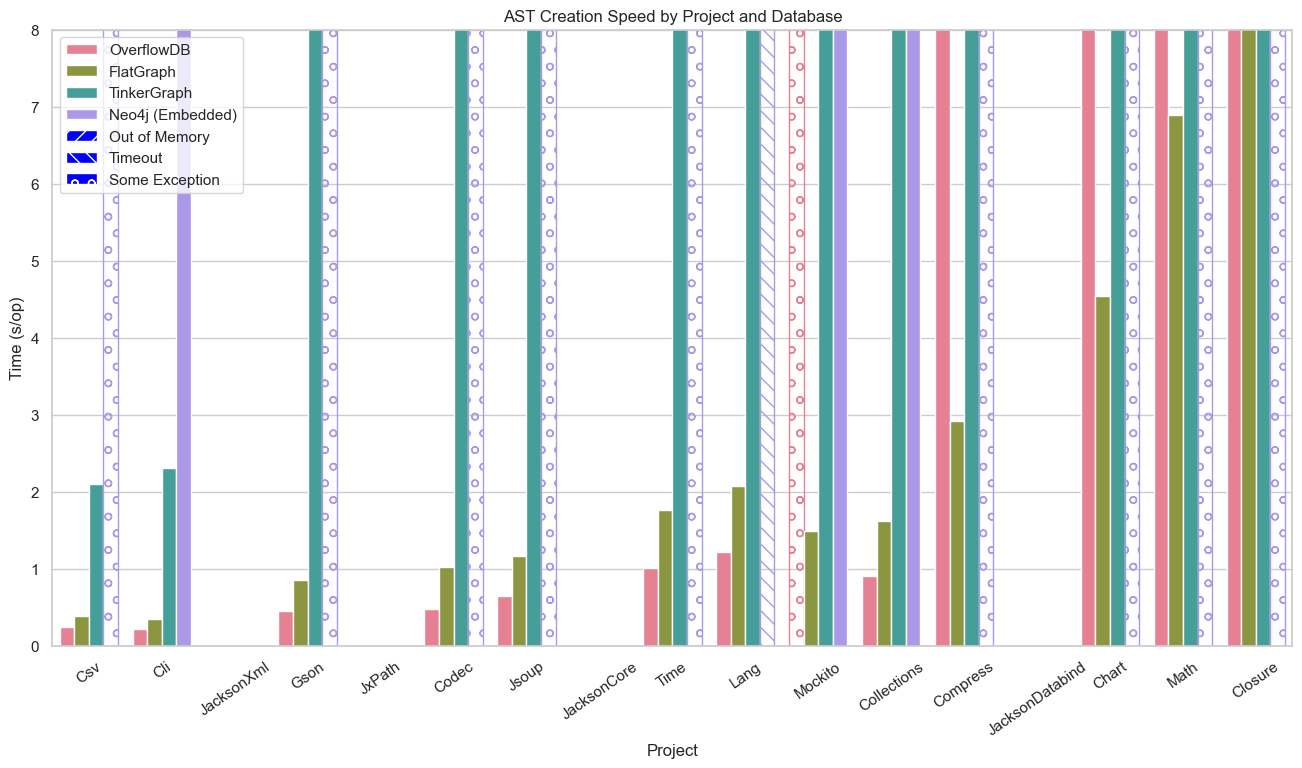

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

write_df_create_ast = final_df[
    (final_df['Type'] == 'write') & (final_df['Benchmark'].str.endswith('createAst')) & (final_df['Mem'] == 8)]

# JAR files in ascending order of size
file_order = ['Csv',
              'Cli',
              'JacksonXml',
              'Gson',
              'JxPath',
              'Codec',
              'Jsoup',
              'JacksonCore',
              'Time',
              'Lang',
              'Mockito',
              'Collections',
              'Compress',
              'JacksonDatabind',
              'Chart',
              'Math',
              'Closure']

# Plotting with Seaborn and Matplotlib
fig, ax1 = plt.subplots(figsize=(16, 8))
sns.set(style="whitegrid")

# Create the bar plot for createAst
palette = sns.color_palette("husl", len(write_df_create_ast['Database'].unique()))
sns.barplot(x="Project", y="Score", hue="Database", data=write_df_create_ast, ax=ax1, palette=palette, order=file_order)

y_limit = 8
# Set labels and title for the first y-axis
ax1.set_xlabel('Project')
ax1.set_ylabel(f'Time ({write_df_create_ast["Unit"].iloc[0]})')
ax1.set_title('AST Creation Speed by Project and Database')
ax1.set_ylim(top=y_limit)

# Log errors as hatch
for patch in ax1.patches:
    h = int(patch.get_height())
    if h in patterns.keys():
        original_color = patch.get_facecolor()
        patch.set_hatch(patterns[h])
        patch.set_facecolor('none')
        patch.set_edgecolor(original_color)

plt.xticks(rotation=35)

handles, labels = plt.gca().get_legend_handles_labels()

# Add the custom entry
handles.append(Patch(facecolor='blue', hatch='//', label='Out of Memory'))
handles.append(Patch(facecolor='blue', hatch='\\\\', label='Timeout'))
handles.append(Patch(facecolor='blue', hatch='o', label='Some Exception'))
plt.legend(handles=handles, loc='best')

# Show the plot
plt.show()

### Read Query Speeds

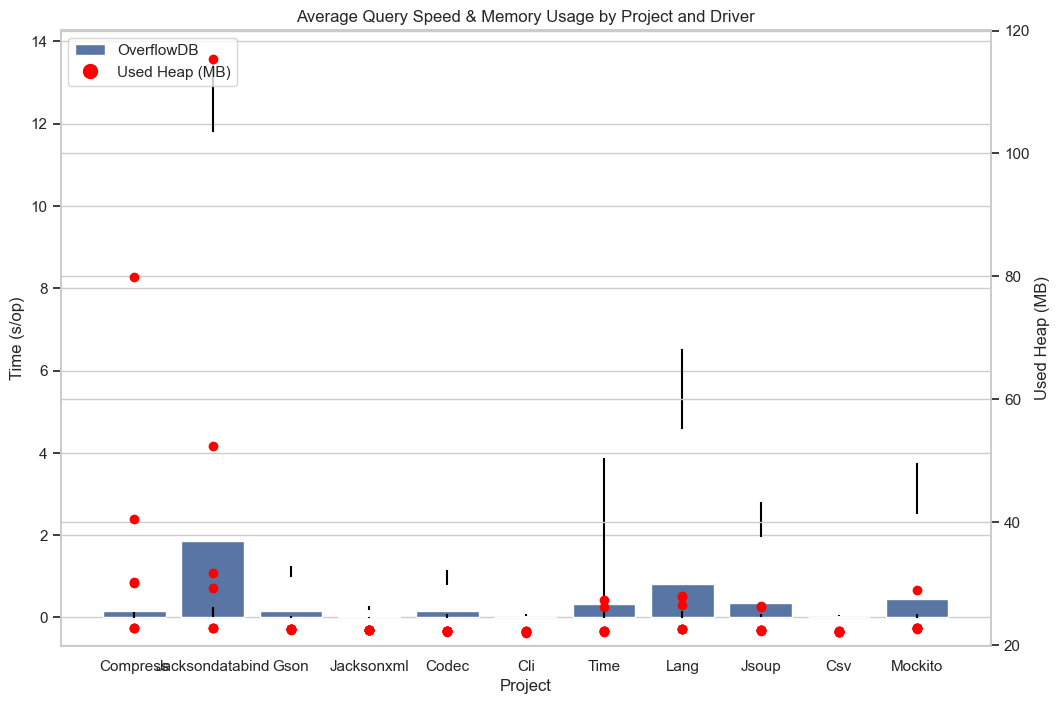

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

read_df_create_ast = final_df[(final_df['Type'] == 'read') & (~final_df['Benchmark'].str.endswith('+liveObjects'))]

# Filter the data for Benchmark ending with 'usedHeap'
filtered_df_usedHeap = final_df[(final_df['Type'] == 'read') & (final_df['Benchmark'].str.endswith('+liveObjects'))]

# Convert 'Score' from bytes to megabytes for 'usedHeap' entries
filtered_df_usedHeap.loc[filtered_df_usedHeap['Unit'] == 'bytes', 'Score'] /= (1024 * 1024)
filtered_df_usedHeap.loc[filtered_df_usedHeap['Unit'] == 'bytes', 'Unit'] = 'megabytes'

# Plotting with Seaborn and Matplotlib
fig, ax1 = plt.subplots(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the bar plot for createAst
sns.barplot(x="Project", y="Score", hue="Database", data=read_df_create_ast, errorbar=None, ax=ax1)

# Adding error bars manually
for i, row in read_df_create_ast.iterrows():
    plt.errorbar(x=row['Project'], y=row['Score'], yerr=row['Error'], fmt='none', c='black')

# Set labels and title for the first y-axis
ax1.set_xlabel('Project')
ax1.set_ylabel(f'Time ({read_df_create_ast["Unit"].iloc[0]})')
ax1.set_title('Average Query Speed & Memory Usage by Project and Driver')

# Create a second y-axis for usedHeap
ax2 = ax1.twinx()

# Add points for usedHeap
ax2.scatter(filtered_df_usedHeap['Project'], filtered_df_usedHeap['Score'], color='red', label='Used Heap (MB)')
ax2.set_ylabel('Used Heap (MB)')

# Adjust the lower limit of ax2 to ensure it is above the minimum of the usedHeap scores
min_used_heap_score = filtered_df_usedHeap['Score'].min()
ax2.set_ylim(bottom=min_used_heap_score * 0.9)  # Set the lower limit to 90% of the minimum usedHeap score

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2 = [plt.Line2D([0], [0], marker='o', color='red', linestyle='', markersize=10)]
labels_2 = ['Used Heap (MB)']
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Show the plot
plt.show()

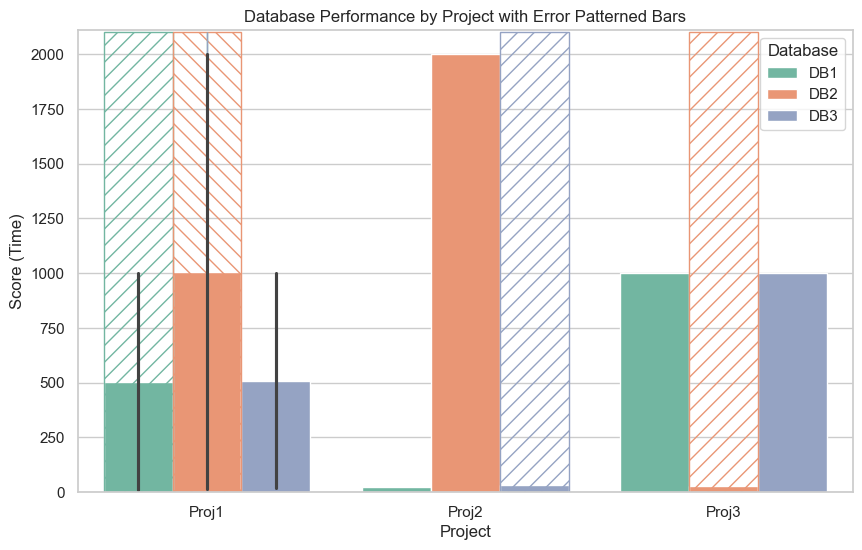

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sample data with an additional project and error cases represented as special scores
data = {
    'Database': ['DB1', 'DB1', 'DB2', 'DB2', 'DB3', 'DB3', 'DB1', 'DB1', 'DB2', 'DB2', 'DB3', 'DB3'],
    'Score': [1000, 10, 15, 2000, 20, 1000, 25, 1000, 30, 2000, 35, 1000],
    'Project': ['Proj1', 'Proj1', 'Proj1', 'Proj1', 'Proj1', 'Proj1', 'Proj2', 'Proj3', 'Proj3', 'Proj2', 'Proj2',
                'Proj3'],
    'Error': [None, 'out of memory', None, 'timeout', None, 'out of memory', None, 'out of memory', None, 'timeout',
              None, 'out of memory']
}

# Create a DataFrame
df = pd.DataFrame(data)

# Define the pattern properties for the errors
patterns = {
    1000: ('//', 'red'),  # out of memory
    2000: ('\\\\', 'blue')  # timeout
}

# Create a barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Project", y="Score", hue="Database", data=df, dodge=True, palette='Set2')

# Get the y-limit of the plot for drawing the patterned bars to the top
y_limit = ax.get_ylim()[1]

# Iterate through the patches of the bars and adjust their patterns if they represent an error
for patch, (index, row) in zip(ax.patches, df.iterrows()):
    score = row['Score']
    if score in patterns:
        # Get the pattern and color based on the error value
        pattern, color = patterns[score]

        # Clear the original bar
        #patch.set_facecolor('none')

        # Add a patterned rectangle on top of the bar
        rect = Rectangle((patch.get_x(), 0), patch.get_width(), y_limit, facecolor='none', hatch=pattern,
                         edgecolor=patch.get_facecolor())
        ax.add_patch(rect)

# Adjust y-axis limits to accommodate the patterned error bars
ax.set_ylim(0, y_limit + 10)

# Set plot title and labels
plt.title('Database Performance by Project with Error Patterned Bars')
plt.xlabel('Project')
plt.ylabel('Score (Time)')
plt.legend(title='Database', loc='upper right')

# Display the plot
plt.show()
